<a href="https://colab.research.google.com/github/chrishendra93/MI_Workshop/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
np.random.seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root_dir = "/content/drive/MyDrive/Journal Club MIL/mnist_clr"

mnist_columns = ["label"] + ["features_{}".format(i) for i in range(28 ** 2)]
mnist_train = pd.read_csv("./sample_data/mnist_train_small.csv", names=mnist_columns)
mnist_test = pd.read_csv("./sample_data/mnist_test.csv", names=mnist_columns)
mnist_arr_train = mnist_train[["features_{}".format(i) for i in range(28 ** 2)]].values
mnist_arr_test = mnist_test[["features_{}".format(i) for i in range(28 ** 2)]].values

X_train = np.load(os.path.join(root_dir, "train_features.npy"))
X_test = np.load(os.path.join(root_dir, "test_features.npy"))
y_train = np.load(os.path.join(root_dir, "train_labels.npy"))
y_test = np.load(os.path.join(root_dir, "test_labels.npy"))

print(np.all(y_train == mnist_train["label"].values))
print(np.all(y_test == mnist_test["label"].values))



True
True


In [ ]:
!pip install umap-learn

     |████████████████████████████████| 80 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 19.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=429e03878c1488e42f562570ce0a1caf555dc066711f1dc769cd77d323845657
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=e3dfc882ba86766c102f7ddf1fdd201cd908afd93672312b93cf6676fc7bf027
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


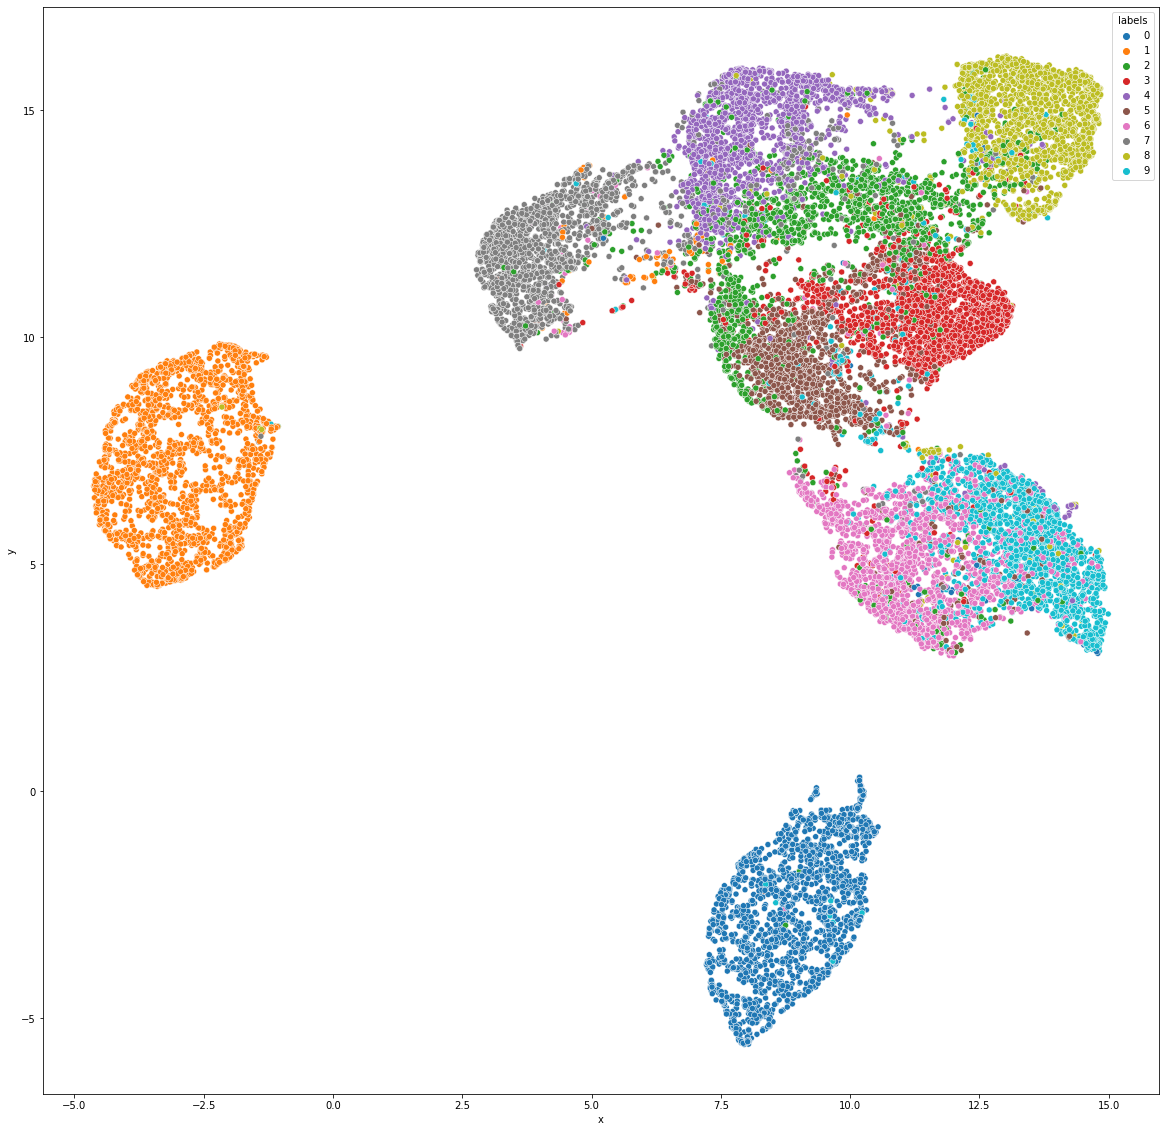

In [ ]:
from umap import UMAP

X_train_umap = UMAP().fit_transform(X_train)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
to_plot_train = pd.DataFrame({'x': X_train_umap[:, 0].flatten(), 
                              'y': X_train_umap[:, 1].flatten(),
                              'labels': y_train})
to_plot_train["labels"] = to_plot_train["labels"].astype('category')
sns.scatterplot(x='x', y='y', data=to_plot_train, hue='labels', ax=ax)


In [18]:
import copy

def create_bags(mnist_df):
    """
    bags: {key1: [ind1, ind2, ind3],
           key2: [ind1, ind2, ind3, ind4, ind5],
           ... }
    bag_lbls:
        {key1: 0,
         key2: 1,
         ... }
    """
    bags = []
    bag_labels = []
    i = 0
    j = 0

    all_indices, all_labels = np.arange(len(mnist_df)), mnist_df["label"].values
    digits_9 = np.argwhere(all_labels == 9).flatten()
    other_digits = np.argwhere(all_labels != 9).flatten()

    np.random.shuffle(other_digits)
    np.random.shuffle(digits_9)

    other_labels = all_labels[other_digits]
    while (j < len(other_digits)) or (j < len(digits_9)):
      bag_size = np.random.randint(8, 15)
      alpha = np.random.uniform(0, 1)
      indices = []
      labels = []
      if alpha <= 0.7:
        # sample random amount of digits 9 from the digits_9 indices
        if i < len(digits_9):
          if j < len(other_digits):
            n_9 = np.random.randint(1, 8)
          else:
            n_9 = bag_size
          
          indices.extend(digits_9[i:i + n_9])
          labels.extend([9 for i in range(n_9)])
          i += n_9
          bag_size -= n_9

      if (j < len(other_digits)) and (bag_size > 0):
        indices.extend(other_digits[j: j + bag_size])
        labels.extend(other_labels[j: j + bag_size])
      
      bag_labels.append(get_bag_label(np.array(labels)))
      bags.append(indices)
      j += bag_size
    return np.array(bags), np.array(bag_labels)

def get_bag_label(instance_labels):
  digits_9 = (instance_labels == 9)
  return (digits_9.sum() >= 3) * 1

def fetch_images(indices, mnist_arr):
  return mnist_arr[indices]

In [19]:
train_bags, train_labels = create_bags(mnist_train)
test_bags, test_labels = create_bags(mnist_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(array([712.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 188.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

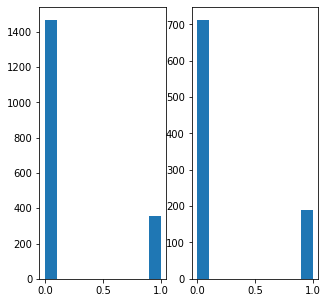

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist(train_labels)
axes[1].hist(test_labels)


(array([  2.,   0., 118., 132.,   0., 114., 121., 135., 127., 151.]),
 array([ 6. ,  6.8,  7.6,  8.4,  9.2, 10. , 10.8, 11.6, 12.4, 13.2, 14. ]),
 <a list of 10 Patch objects>)

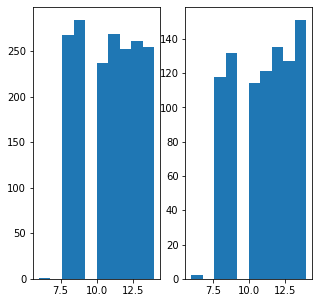

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist([len(bag) for bag in train_bags])
axes[1].hist([len(bag) for bag in test_bags])


In [22]:
print(len(train_bags))
print(len(test_bags))

1825
900


In [52]:
def visualize_bags(mnist_arr, bags, bag_labels, n_bags):
  pos_bags = np.argwhere(bag_labels == 1).flatten()
  neg_bags = np.argwhere(bag_labels == 0).flatten()
  n_pos = (n_bags // 2 )
  n_neg = n_bags - n_pos
  sampled_indices = np.concatenate([np.random.choice(pos_bags, n_pos, replace=False), np.random.choice(neg_bags, n_neg, replace=False)])
  sampled_bags = bags[sampled_indices]
  sampled_bag_labels = bag_labels[sampled_indices] 
  max_instances_num = np.max([len(bag) for bag in sampled_bags])
  _, axes = plt.subplots(len(sampled_bags), max_instances_num,
                         figsize=(10 * len(sampled_bags), 
                                  10 * max_instances_num))
  for idx, bag, bag_label in zip(np.arange(n_bags), sampled_bags, sampled_bag_labels):
    ax = axes[idx, :]
    instance_size = None
    for i in range(max_instances_num):
      if i >= len(bag):
        ax[i].imshow(np.zeros(instance_size)) # Pad with empty images if bag has fewer instances than max
      else:
        img = mnist_arr[bag[i]]
        if instance_size is None:
          w = int(np.sqrt(len(img)))
          instance_size = (w, w)
        ax[i].imshow(img.reshape(instance_size))
      if i == max_instances_num // 2:
        ax[i].set_title('Bag Label: {}'.format(bag_label), fontsize=50)
  plt.subplots_adjust(bottom=0.1, top=0.3, hspace=0.2)


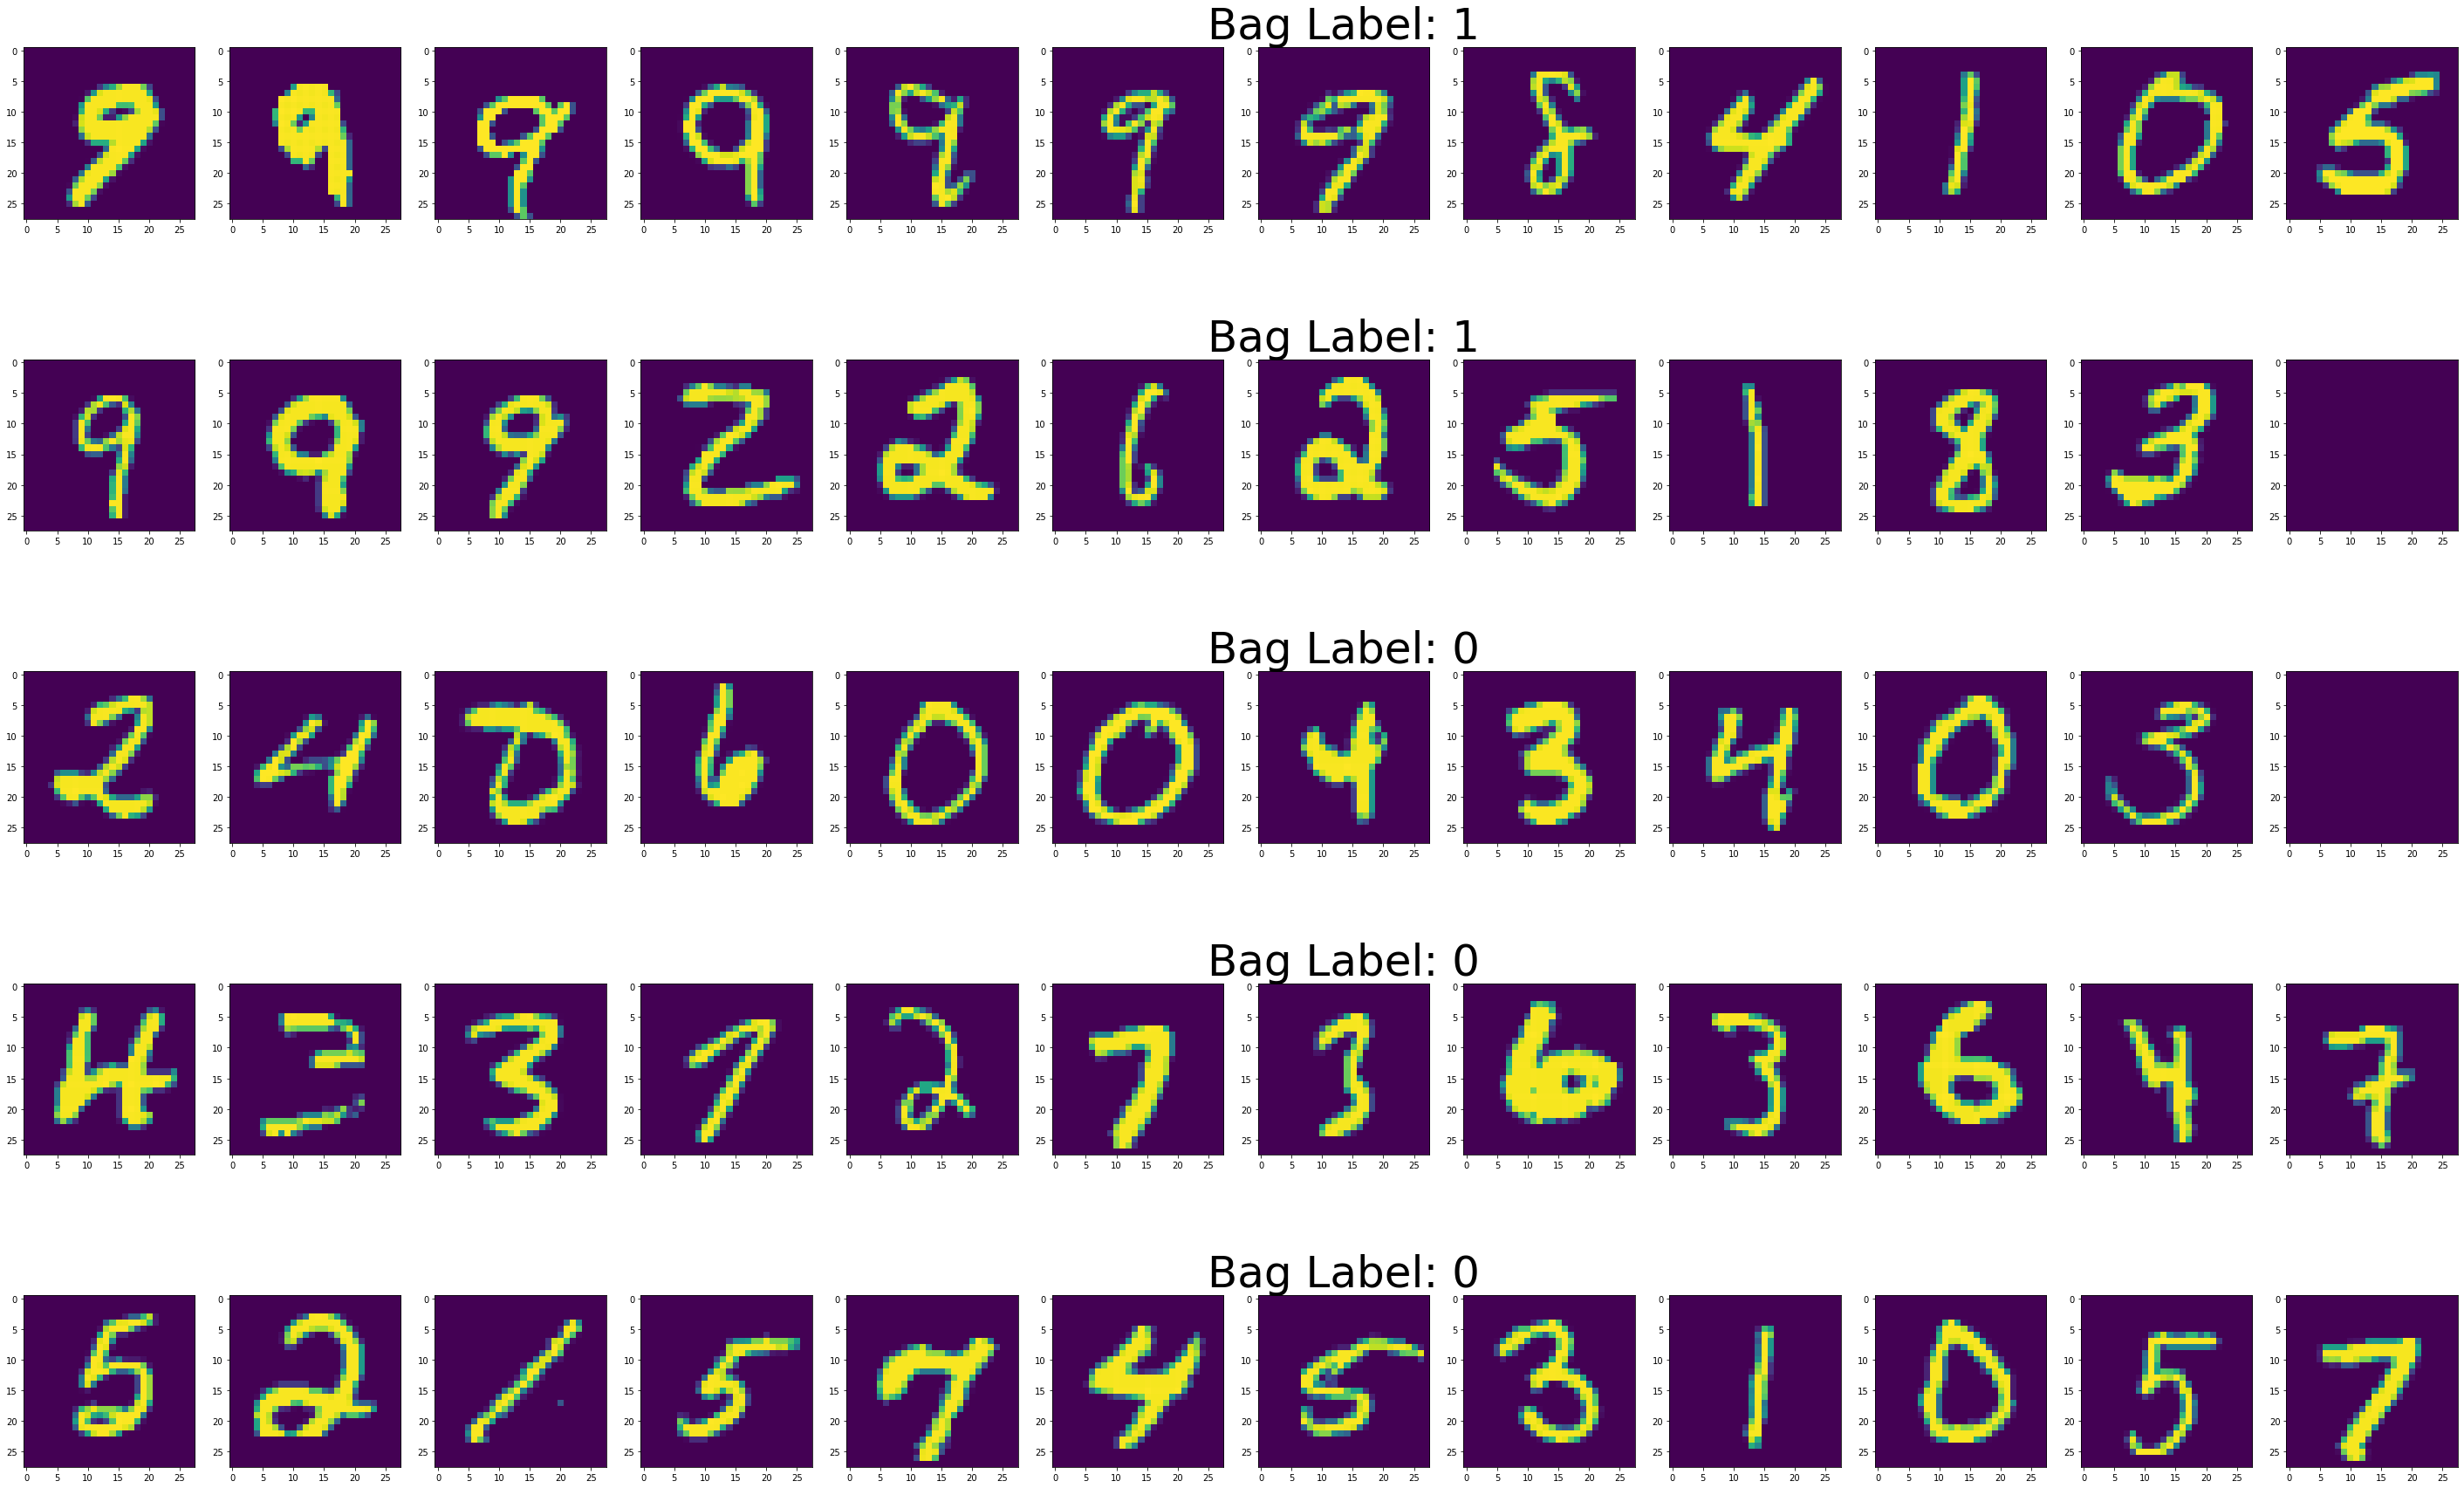

In [53]:
visualize_bags(mnist_arr_train, train_bags, train_labels, 5)

In [27]:
from scipy.stats import kurtosis
from functools import partial
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def fetch_instances(mnist_features, indices):
  return mnist_features[indices]

def extract_summary_stats(mnist_features, bags, summary_funcs=[np.mean]):
  summary_stats = []
  for summary_func in summary_funcs:
    summary_func = partial(summary_func, axis=0)
    summary_stat = np.array([summary_func(mnist_features[bag]) for bag in bags]).reshape(-1, 64)
    summary_stats.append(summary_stat)
  return np.concatenate(summary_stats, axis=1)

In [28]:
X_train_stats = extract_summary_stats(X_train, train_bags, [np.mean, np.var, kurtosis])
X_test_stats = extract_summary_stats(X_test, test_bags, [np.mean, np.var, kurtosis])

In [29]:
scaler = StandardScaler().fit(X_train_stats)
pca_obj = PCA().fit(scaler.transform(X_train_stats))
X_train_pca = pca_obj.transform(scaler.transform(X_train_stats))
X_test_pca = pca_obj.transform(scaler.transform(X_test_stats))

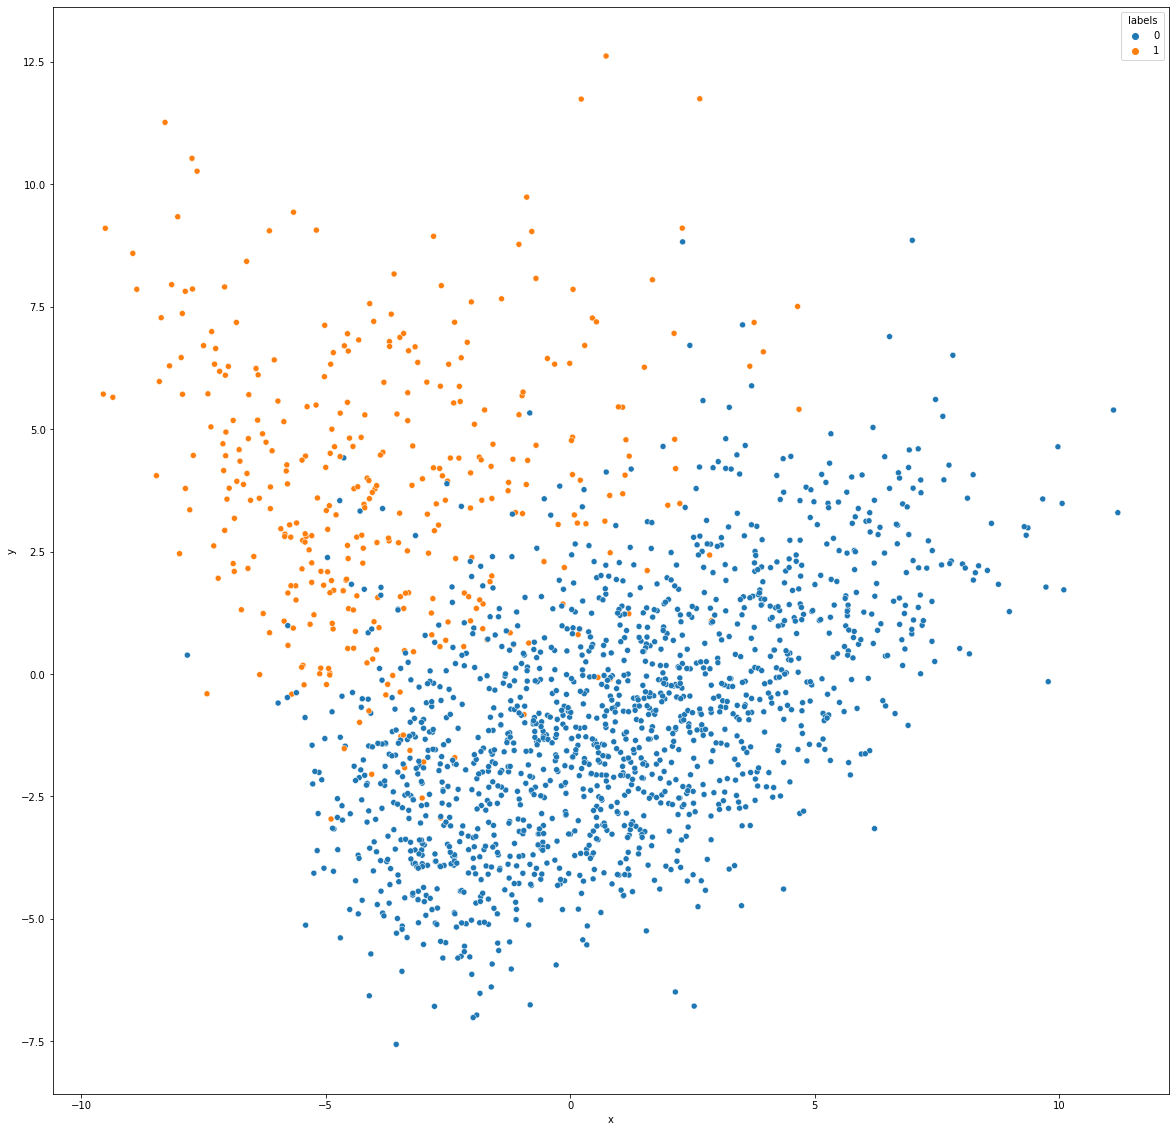

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
to_plot_train = pd.DataFrame({'x': X_train_pca[:, 0].flatten(), 
                              'y': X_train_pca[:, 1].flatten(),
                              'labels': train_labels})
to_plot_train["labels"] = to_plot_train["labels"].astype('category')
sns.scatterplot(x='x', y='y', data=to_plot_train, hue='labels', ax=ax)

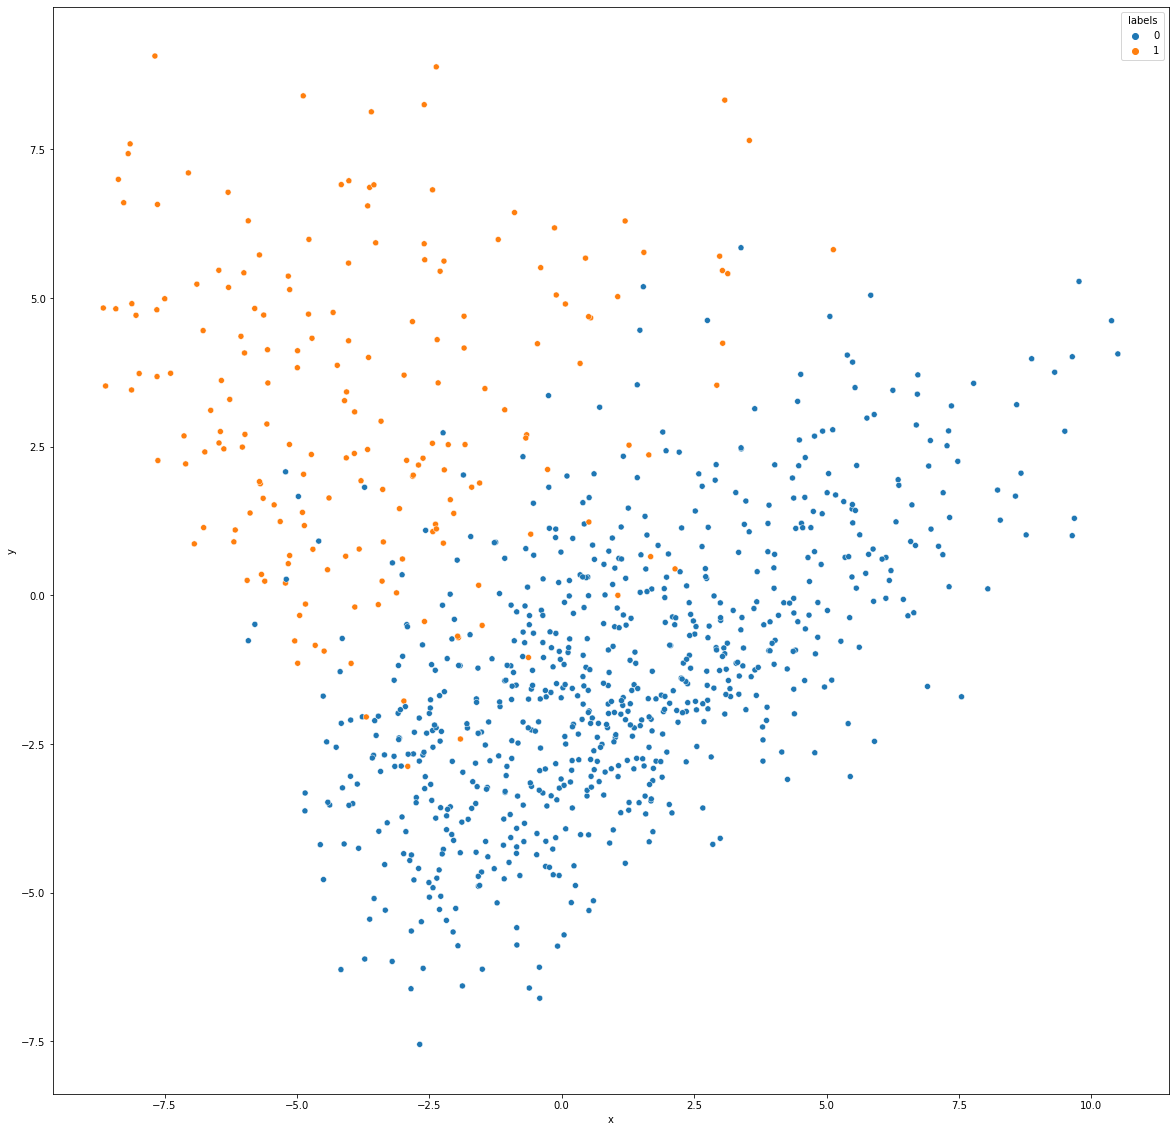

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
to_plot_test = pd.DataFrame({'x': X_test_pca[:, 0].flatten(), 
                              'y': X_test_pca[:, 1].flatten(),
                              'labels': test_labels})
to_plot_test["labels"] = to_plot_test["labels"].astype('category')
sns.scatterplot(x='x', y='y', data=to_plot_test, hue='labels', ax=ax)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_curve, precision_recall_curve, auc
from scipy.stats import mode

In [36]:
def get_roc_auc(y_true, y_pred):
    fpr, tpr, _  = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def get_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def get_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)

In [37]:
summary_statistics_list = {'mean': [np.mean], 'var': [np.var], 'kurtosis': [kurtosis],
                           'mean_var': [np.mean, np.var], 'mean_kurtosis': [np.mean, kurtosis], 'var_kurtosis': [np.var, kurtosis],
                           'mean_var_kurtosis': [np.mean, np.var, kurtosis]}

df = []
for summary_statistics, stats_func in summary_statistics_list.items():

  X_train_stats = extract_summary_stats(X_train, train_bags, stats_func)
  X_test_stats = extract_summary_stats(X_test, test_bags, stats_func)
  model = LogisticRegression(max_iter=10000).fit(X_train_stats, train_labels)
  y_test_pred = model.predict(X_test_stats)
  balanced_accuracy = balanced_accuracy_score(test_labels, y_test_pred)
  roc_auc = get_roc_auc(test_labels, y_test_pred)
  pr_auc = get_pr_auc(test_labels, y_test_pred)
  df += [(summary_statistics, roc_auc, pr_auc, balanced_accuracy)]

df = pd.DataFrame(df, columns=['Model', 'ROC AUC', 'PR AUC', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)
df

,Model,ROC AUC,PR AUC,Balanced Accuracy
4,mean_kurtosis,0.822914,0.839983,0.822914
6,mean_var_kurtosis,0.822914,0.839983,0.822914
0,mean,0.801787,0.835682,0.801787
3,mean_var,0.801787,0.835682,0.801787
5,var_kurtosis,0.653359,0.602738,0.653359
2,kurtosis,0.647337,0.591215,0.647337
1,var,0.500000,0.604444,0.500000


In [38]:
from sklearn.metrics import pairwise_distances

def get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='max', quantile=0.7):
  pairwise_distance = pairwise_distances(X_test, X_train)
  all_bag_distances = []
  
  for test_bag in tqdm(test_bags, total=len(test_bags)):
    test_bag_instances = pairwise_distance[test_bag]
    bag_distances = []

    for train_bag in train_bags:
      if mode == 'max':
        test_train_distance = np.max(np.min(test_bag_instances[:, train_bag], axis=1))
        train_test_distance = np.max(np.min(test_bag_instances[:, train_bag].transpose(), axis=1))
        bag_distances.append(max(test_train_distance, train_test_distance))
      
      elif mode =='avg':
        test_train_distance = np.min(test_bag_instances[:, train_bag], axis=1)
        train_test_distance = np.min(test_bag_instances[:, train_bag].transpose(), axis=1)
        bag_distances.append(np.mean(np.concatenate([train_test_distance, test_train_distance])))
      
      elif mode == 'min':
        test_train_distance = np.min(np.min(test_bag_instances[:, train_bag], axis=1))
        train_test_distance = np.min(np.min(test_bag_instances[:, train_bag].transpose(), axis=1))
        bag_distances.append(max(test_train_distance, train_test_distance))
      elif mode == 'quantile':
        test_train_distance = np.quantile(np.min(test_bag_instances[:, train_bag], axis=1), quantile)
        train_test_distance = np.quantile(np.min(test_bag_instances[:, train_bag].transpose(), axis=1), quantile)
        bag_distances.append(max(test_train_distance, train_test_distance))
    all_bag_distances.append(np.array(bag_distances).reshape(1, -1))
  all_bag_distances = np.concatenate(all_bag_distances, axis=0)
  return all_bag_distances


In [39]:
bag_distances_max = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='max')
bag_distances_avg = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='avg')
bag_distances_min = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='min')
bag_distances_q07 = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='quantile', quantile=0.7)
bag_distances_q08 = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='quantile', quantile=0.8)

In [40]:
from scipy.stats import mode

def get_knn_pred(train_labels, test_labels, all_bag_distances, n_neighbors):
  return mode(train_labels[np.argsort(all_bag_distances, axis=1)[:, :n_neighbors]], axis=1)[0].flatten()


def get_citation_knn_pred(train_labels, test_labels, all_bag_distances, n_ref_neighbors=10, n_cit_neighbors=10):
  reference_nn = train_labels[np.argsort(all_bag_distances, axis=1)[:, :n_ref_neighbors]]
  num_pos_neighbors = np.sum(reference_nn, axis=1)
  num_neg_neighbors = n_ref_neighbors - num_pos_neighbors
  reference_nn_labels = np.concatenate([num_neg_neighbors.reshape(-1, 1),
                                        num_pos_neighbors.reshape(-1, 1)], axis=1)
  citer_nn_labels = get_citation_counts(train_labels, test_labels, all_bag_distances, n_cit_neighbors)
  return reference_nn_labels + citer_nn_labels

def get_citation_counts(train_labels, test_labels, all_bag_distances, n_neighbors):
  test_pos_neg_counts = np.zeros((len(test_labels), 2))
  nn = np.argsort(all_bag_distances.transpose(), axis=1)[:, :n_neighbors]
  for citer in range(len(nn)):
    citations = nn[citer]
    citer_label = np.array([0, 1]) if train_labels[citer] == 1 else np.array([1, 0])
    for citation in citations:
      test_pos_neg_counts[citation, :] += citer_label
  return test_pos_neg_counts






In [41]:
n_neighbors_ref = 5
n_neighbors_cit = 5

df_knn = []

for distance_mode, distance in zip(['max', 'avg', 'min', 'q70', 'q80'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
  y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_knn += [(distance_mode, balanced_acc)]
df_knn = pd.DataFrame(df_knn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df_cknn = []

for distance_mode, distance in zip(['max', 'avg', 'min', 'q70', 'q80'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
  y_pred_test_knn = np.argmax(get_citation_knn_pred(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_cknn += [(distance_mode, balanced_acc)]
df_cknn = pd.DataFrame(df_cknn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df = df_knn.merge(df_cknn, on=["Distance Type"], suffixes=['_knn', '_cknn'])
df

,Distance Type,Balanced Accuracy_knn,Balanced Accuracy_cknn
0,avg,0.902403,0.870787
1,q70,0.885295,0.853977
2,q80,0.863316,0.828786
3,max,0.738869,0.699020
4,min,0.570105,0.590127


In [42]:
n_neighbors_ref = 10
n_neighbors_cit = 5

df_knn = []

for distance_mode, distance in zip(['max', 'avg', 'min', 'q70', 'q80'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
  y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_knn += [(distance_mode, balanced_acc)]
df_knn = pd.DataFrame(df_knn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df_cknn = []

for distance_mode, distance in zip(['max', 'avg', 'min', 'q70', 'q80'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
  y_pred_test_knn = np.argmax(get_citation_knn_pred(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_cknn += [(distance_mode, balanced_acc)]
df_cknn = pd.DataFrame(df_cknn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df = df_knn.merge(df_cknn, on=["Distance Type"], suffixes=['_knn', '_cknn'])
df

,Distance Type,Balanced Accuracy_knn,Balanced Accuracy_cknn
0,avg,0.884637,0.884084
1,q70,0.871743,0.864616
2,q80,0.854530,0.832701
3,max,0.691041,0.698467
4,min,0.563128,0.586361


In [43]:
n_neighbors_ref = 15
n_neighbors_cit = 5

df_knn = []

for distance_mode, distance in zip(['max', 'avg', 'min', 'q70', 'q80'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
  y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_knn += [(distance_mode, balanced_acc)]
df_knn = pd.DataFrame(df_knn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df_cknn = []

for distance_mode, distance in zip(['max', 'avg', 'min', 'q70', 'q80'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
  y_pred_test_knn = np.argmax(get_citation_knn_pred(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_cknn += [(distance_mode, balanced_acc)]
df_cknn = pd.DataFrame(df_cknn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df = df_knn.merge(df_cknn, on=["Distance Type"], suffixes=['_knn', '_cknn'])
df

,Distance Type,Balanced Accuracy_knn,Balanced Accuracy_cknn
0,avg,0.905914,0.882127
1,q70,0.889658,0.862658
2,q80,0.888402,0.845999
3,max,0.713573,0.697212
4,min,0.573766,0.579085


In [44]:
n_neighbors_ref = 15
n_neighbors_cit = 3

df_knn = []

for distance_mode, distance in zip(['max', 'avg', 'min', 'q70', 'q80'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
  y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_knn += [(distance_mode, balanced_acc)]
df_knn = pd.DataFrame(df_knn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df_cknn = []

for distance_mode, distance in zip(['max', 'avg', 'min', 'q70', 'q80'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
  y_pred_test_knn = np.argmax(get_citation_knn_pred(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_cknn += [(distance_mode, balanced_acc)]
df_cknn = pd.DataFrame(df_cknn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df = df_knn.merge(df_cknn, on=["Distance Type"], suffixes=['_knn', '_cknn'])
df

,Distance Type,Balanced Accuracy_knn,Balanced Accuracy_cknn
0,avg,0.905914,0.884084
1,q70,0.889658,0.863211
2,q80,0.888402,0.855232
3,max,0.713573,0.694552
4,min,0.573766,0.579085


In [45]:
from itertools import permutations

In [46]:
neighbor_pairs = permutations(np.arange(1, 31), 2)
params_df = []
distance = bag_distances_avg
for pair in tqdm(neighbor_pairs):
  n_neighbors_ref, n_neighbors_cit = pair
  y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
  balanced_acc_knn = balanced_accuracy_score(test_labels, y_pred_test_knn)
  y_pred_test_cknn = np.argmax(get_citation_knn_pred(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
  balanced_acc_cknn = balanced_accuracy_score(test_labels, y_pred_test_cknn)
  params_df += [(n_neighbors_ref, n_neighbors_cit, balanced_acc_knn, balanced_acc_cknn)]

params_df = pd.DataFrame(params_df, columns=['N_neighbors_ref', 'N_neighbors_cit', 'Balanced Accuracy KNN', 'Balanced Accuracy Citation-KNN']).sort_values("Balanced Accuracy Citation-KNN", ascending=False)



In [51]:
def get_citation_knn_pred_normalized(train_labels, test_labels, all_bag_distances, n_ref_neighbors=10, n_cit_neighbors=10):
  reference_nn = train_labels[np.argsort(all_bag_distances, axis=1)[:, :n_ref_neighbors]]
  num_pos_neighbors = np.sum(reference_nn, axis=1)
  num_neg_neighbors = n_ref_neighbors - num_pos_neighbors
  reference_nn_labels = np.concatenate([num_neg_neighbors.reshape(-1, 1),
                                        num_pos_neighbors.reshape(-1, 1)], axis=1)
  citer_nn_labels = get_citation_counts(train_labels, test_labels, all_bag_distances, n_cit_neighbors)
  return reference_nn_labels / np.sum(reference_nn_labels, axis=0) + citer_nn_labels / np.sum(citer_nn_labels, axis=0)

In [48]:
n_neighbors_ref = 15
n_neighbors_cit = 3

df_knn = []

for distance_mode, distance in zip(['max', 'avg', 'min', 'q70', 'q80'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
  y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_knn += [(distance_mode, balanced_acc)]
df_knn = pd.DataFrame(df_knn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df_cknn = []

for distance_mode, distance in zip(['max', 'avg', 'min', 'q70', 'q80'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
  y_pred_test_knn = np.argmax(get_citation_knn_pred_normalized(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_cknn += [(distance_mode, balanced_acc)]
df_cknn = pd.DataFrame(df_cknn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df = df_knn.merge(df_cknn, on=["Distance Type"], suffixes=['_knn', '_cknn'])
df

,Distance Type,Balanced Accuracy_knn,Balanced Accuracy_cknn
0,avg,0.905914,0.939398
1,q70,0.889658,0.915671
2,q80,0.888402,0.914266
3,max,0.713573,0.819149
4,min,0.573766,0.684990


In [49]:
neighbor_pairs = permutations(np.arange(1, 31), 2)
params_df = []
distance = bag_distances_avg
for pair in tqdm(neighbor_pairs):
  n_neighbors_ref, n_neighbors_cit = pair
  y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
  balanced_acc_knn = balanced_accuracy_score(test_labels, y_pred_test_knn)
  y_pred_test_cknn = np.argmax(get_citation_knn_pred_normalized(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
  balanced_acc_cknn = balanced_accuracy_score(test_labels, y_pred_test_cknn)
  params_df += [(n_neighbors_ref, n_neighbors_cit, balanced_acc_knn, balanced_acc_cknn)]

params_df = pd.DataFrame(params_df, columns=['N_neighbors_ref', 'N_neighbors_cit', 'Balanced Accuracy KNN', 'Balanced Accuracy Citation-KNN']).sort_values("Balanced Accuracy Citation-KNN", ascending=False)



In [50]:
params_df

,N_neighbors_ref,N_neighbors_cit,Balanced Accuracy KNN,Balanced Accuracy Citation-KNN
398,14,23,0.892063,0.956207
782,27,30,0.883382,0.956207
347,12,30,0.886744,0.956207
397,14,22,0.892063,0.956207
663,23,27,0.886042,0.956057
...,...,...,...,...
5,1,7,0.881081,0.899549
2,1,4,0.881081,0.899399
3,1,5,0.881081,0.897442
1,1,3,0.881081,0.887506


In [58]:
np.save("train_labels.npy", train_labels)
np.save("train_bags.npy", train_bags)

np.save("test_labels.npy", test_labels)
np.save("test_bags.npy", test_bags)


In [61]:
from google.colab import files

files.download('train_bags.npy') 
files.download('train_labels.npy') 

files.download('test_bags.npy') 
files.download('test_labels.npy') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>